In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm



In [2]:
labels = pd.read_csv("../Data/pneumonia_classification/stage_2_train_labels.csv")

labels.shape

(30227, 6)

In [3]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
labels = labels.drop_duplicates("patientId")
labels.shape

(26684, 6)

In [5]:
ROOT_PATH = Path("../Data/pneumonia_classification/stage_2_train_images")
SAVE_PATH = Path("../Data/pneumonia_classification/Processed")

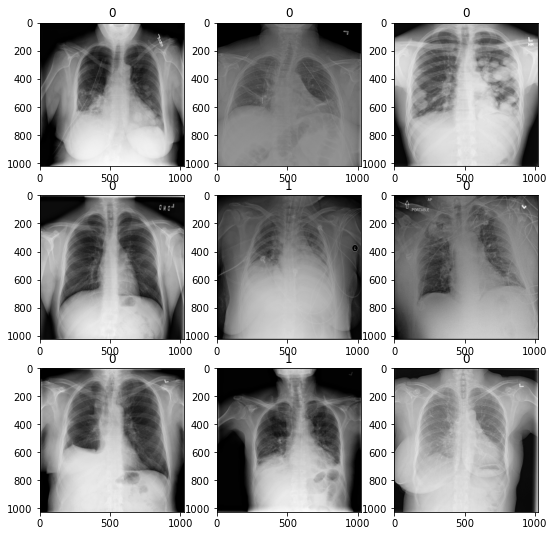

In [6]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0

for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")

        dcm = pydicom.read_file(dcm_path).pixel_array

        label = labels["Target"].iloc[c]

        axis[i][j].imshow(dcm, cmap = "gray")
        axis[i][j].set_title(label)
        c += 1


In [16]:
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")

    dcm = pydicom.read_file(dcm_path).pixel_array / 255
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    label = labels["Target"].iloc[c]

    train_or_val = "train" if c < 24000 else "val"

    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)

    normalizer = 224*224
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer

100%|█████████████████████████████████████| 26684/26684 [07:12<00:00, 61.71it/s]


In [19]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean ** 2)

In [20]:
mean, std

(0.4903962485384803, 0.24795070634161256)